<a href="https://colab.research.google.com/github/Amal1703/Spam_classification_using_LSTM.ipynb/blob/main/Spam_classification_using_LSTM_%26_Naive_Bayes_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import kagglehub
import shutil
import os
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import json
from IPython.display import Image
from keras import layers
from tensorflow.keras.preprocessing.text import tokenizer_from_json
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report
import nltk, re, collections, pickle
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

**Download data**

In [ ]:
# 1. Download to KaggleHub default cache
src_path = kagglehub.dataset_download("uciml/sms-spam-collection-dataset")

# 2. Choose your target directory
dst_path = "/content/"

# 3. Copy all files from cache to your directory
shutil.copytree(src_path, dst_path, dirs_exist_ok=True)

100%|██████████| 211k/211k [00:00<00:00, 385kB/s]

Extracting files...


'/content/'

**Drop null messages and duplicate messages**

In [ ]:
df_spam = pd.read_csv('spam.csv', encoding = 'latin-1')

In [ ]:
df_spam=df_spam.iloc[:,:2] # Ham messages are legitimate, spam messages are unwanted
df_spam.columns = ['feature', 'message']

In [ ]:
print("Number of null messages:", df_spam['message'].isnull().sum())

Number of null messages: 0


In [ ]:
print("Number of duplicate messages:", df_spam['message'].duplicated().sum())

Number of duplicate messages: 403


In [ ]:
# Find duplicated messages with their index
dupes = df_spam[df_spam['message'].duplicated(keep=False)]

# Print index and message
#for idx, row in dupes.iterrows():
  #  print(idx, row['message'])

In [ ]:
# Delete duplicated messages
df_spam = df_spam.drop_duplicates(subset='message', keep='first')

In [ ]:
df_spam.shape, df_spam.columns

((5169, 2), Index(['feature', 'message'], dtype='object'))

In [ ]:
df_spam[df_spam["feature"] == "ham"].shape, df_spam[df_spam["feature"] == "spam"].shape

((4516, 2), (653, 2))

In [ ]:
# Reset the index
df_spam = df_spam.reset_index(drop=True)

**Data preprocessing: cleaning, tokenization and lemmatization**

In [ ]:
# List to store the cleaned messages
cleaned_messages = []

# NLTK object for lemmatizing words (e.g., reduce "running" → "run", cars → car)
lemmatizer = WordNetLemmatizer()

for i in range(df_spam.shape[0]):
    mess_i = df_spam.iloc[i, 1] # Message i

    # Replace emails, URLs, phone numbers and numbers with standardized tokens (emailaddr, httpaddr, etc.)
    mess_i = re.sub(r'\b[\w\-.]+?@\w+?\.\w{2,4}\b', 'emailaddr', mess_i)
    mess_i = re.sub(r'(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)', 'httpaddr', mess_i)
    mess_i = re.sub(r'\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b', 'phonenumbr', mess_i)
    mess_i = re.sub(r'\d+(\.\d+)?', 'numbr', mess_i)

    # Replace common smileys with standardized tokens
    mess_i = re.sub(r'(:\)|:-\)|\(:)', ' SMILE ', mess_i)
    mess_i = re.sub(r'(:\(|:-\(|\):)', ' SAD ', mess_i)
    mess_i = re.sub(r'(;\)|;-\))', ' WINK ', mess_i)
    mess_i = re.sub(r'(:D|:-D)', ' LAUGH ', mess_i)
    mess_i = re.sub(r'(:P|:-P|:p)', ' TONGUE ', mess_i)
    mess_i = re.sub(r'(:O|:-O)', ' SURPRISE ', mess_i)
    mess_i = re.sub(r'(:/|:-/)', ' CONFUSED ', mess_i)
    mess_i = re.sub(r'(:\'\(|:\'-\()', ' CRY ', mess_i)
    mess_i = re.sub(r'(:\||:-\|)', ' NEUTRAL ', mess_i)
    mess_i = re.sub(r'(>:\()', ' ANGRY ', mess_i)
    mess_i = re.sub(r'(<3)', ' HEART ', mess_i)

    # Replace the two symbols £ and $ with moneysymb: why keep these two symbols instead of removing them, since many spam messages contain money symbols (e.g., "You won $1000")
    mess_i = re.sub(r'£|\$', 'moneysymb', mess_i)

    # Remove all special characters and digits, keep only letters
    mess_i = re.sub('[^\w\d\s]', ' ', mess_i)

    # Convert message to lowercase
    mess_i = re.sub('[^A-Za-z]', ' ', mess_i).lower()

    # Convert message to tokens (words)
    token_messages = word_tokenize(mess_i)

    # Lemmatize each token in the message
    mess = []
    for word in token_messages:
        if word not in set(stopwords.words('english')): # stopwords.words('english'): liste de mots très fréquents en anglais : ['the', 'is', 'in', 'and', ...]
            mess.append(lemmatizer.lemmatize(word)) # Réduit le mot à sa forme de base (eg., cars → car, running → run)

    # Convert the list of tokens into a space-separated string: eg., ['hello', 'spam', 'message'] → "hello spam message"
    txt_mess = " ".join(mess)

    # Append the cleaned message
    cleaned_messages.append(txt_mess)

<>:33: SyntaxWarning: invalid escape sequence '\w'
<>:33: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipython-input-2510120849.py:33: SyntaxWarning: invalid escape sequence '\w'
  mess_i = re.sub('[^\w\d\s]', ' ', mess_i)


In [ ]:
y = df_spam.iloc[:, 0] # ham or spam

**Split data**

We split the dataset indices into 70% for training, 20% for testing and 10% for validation. We split the indices because we will test two algorithms: LSTM and Naive Bayes classifier.

- Why split the indices and not just the data?

To train an LSTM, we need the entire message sequence in order, because LSTMs are sequence models that depend on word order. On the other hand, Naive Bayes and classical models like SVM, Logistic Regression, and Random Forest do not take word order into account—they treat text as a bag of words.

- Example:

For LSTM, word order is crucial: "The cat eats the rat" ≠ "The rat eats the cat".

For classical models, "The rat eats the cat" and "The cat eats the rat" are the same, because their numerical representations produce identical vectors.

In [ ]:
# Print the 2 labels : 'spam', 'ham'
print(list(set(y)))

Indice_train=[]
Indice_test=[]
Indice_val=[]

num_classes = len(set(y))

# Split all message indices (ham and spam) into train, val, and test
for i in range (num_classes):

# Indices of messages labeled as ham or spam
 indices = np.where(y == list(set(y))[i])[0]

# 70% train, 30% temp for each label
 Indice_train_1, Indice_temp= train_test_split(indices,test_size=0.3, random_state=50)

# from temp data: 10% val, 20% test
 Indice_val_1, Indice_test_1 = train_test_split(Indice_temp,test_size=0.66, random_state=50)

# Concatenate the indices of two labels
 Indice_train.extend(Indice_train_1)
 Indice_test.extend(Indice_test_1)
 Indice_val.extend(Indice_val_1)

['ham', 'spam']


**I/ Naive Bayes Classifier**

**Step 1:** Convert the words of the message into a numerical representation

For classical models (Naive Bayes classifier): we can use CountVectorizer or TfidfVectorizer.

CountVectorizer → Transforms text into numbers: these numbers represent how many times each word appears.

TfidfVectorizer → Converts text into weighted values for each word, representing the importance of the word in the message.


1.1 CountVectorizer

In [ ]:
# Size of vocabulary
size_vocabulary = 2000

CountVector = CountVectorizer(max_features = size_vocabulary)

# Apply CountVectorizer to the training messages
X_CountVector = CountVector.fit_transform(np.array(cleaned_messages)[Indice_train]).toarray()
print(CountVector.get_feature_names_out())
print(X_CountVector)
print(X_CountVector.shape)

['aah' 'aathi' 'abi' ... 'zed' 'zindgi' 'zoe']
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(3618, 2000)


1.2 TfidfVectorizer

In [ ]:
tfidf = TfidfVectorizer()

# Apply TfidfVectorizer to the training messages
X_tfidf = tfidf.fit_transform(np.array(cleaned_messages)[Indice_train]).toarray()

print(tfidf.get_feature_names_out())
print(X_tfidf)
print(X_tfidf.shape)

['aah' 'aaniye' 'aaooooright' ... 'zoom' 'zouk' 'zyada']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(3618, 5783)


We will use TfidfVectorizer for numerical transformation

In [ ]:
X_train = X_tfidf

# Save TfidfVectorizer
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

In [ ]:
# Load TfidfVectorizer
with open("tfidf_vectorizer.pkl", "rb") as f:
    tfidf_loaded = pickle.load(f)

# Transform val and test messages into vectors using the saved TfidfVectorizer
X_val = tfidf_loaded.transform(np.array(cleaned_messages)[Indice_val]).toarray()
X_test = tfidf_loaded.transform(np.array(cleaned_messages)[Indice_test]).toarray()

In [ ]:
# Split y into training, validation and test sets
y_train = y[Indice_train]
y_val = y[Indice_val]
y_test = y[Indice_test]

**Step 2:** Train the model

In [ ]:
# Guassian Naive Bayes
model_GaussianNB = GaussianNB().fit(X_train, y_train)

**Step 3:** Make predictions on the test set

In [ ]:
y_pred_GNB_test = model_GaussianNB.predict(X_test)

**Step 4:** Confusion matrix

Classification report:

               precision    recall  f1-score   support

         ham       0.97      0.89      0.93       895
        spam       0.51      0.81      0.63       130

    accuracy                           0.88      1025
   macro avg       0.74      0.85      0.78      1025
weighted avg       0.91      0.88      0.89      1025
 



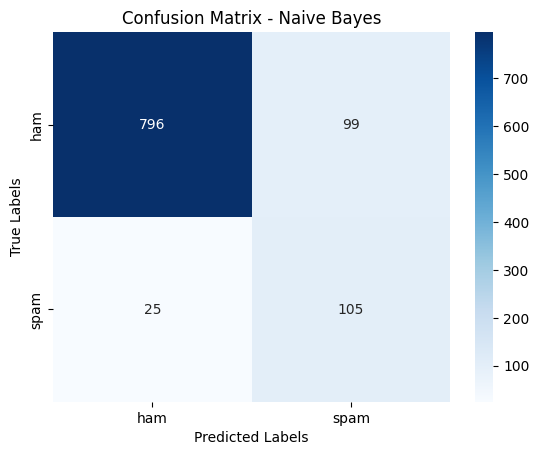

In [ ]:
# confusion matrix : Rows → true labels (y_test), Columns → predicted labels (y_pred_GNB_test)
conf_m_GNB = confusion_matrix(y_test, y_pred_GNB_test)

# Classification report
class_rep_GNB = classification_report(y_test, y_pred_GNB_test)
print('Classification report:\n\n', class_rep_GNB, '\n')

# Plot confusion matrix : row 0 = ham, row 1 = spam
sns.heatmap(conf_m_GNB, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()

# ham
# precision = 0.97 → quand le modèle prédit “spam”, il n’a raison que 97% du temps
# recall = 0.89 → sur tous les vrais messages ham, il en détecte 89% seulement
# support = 895 → beaucoup de ham dans le test set

# Spam
# precision = 0.51 → quand le modèle prédit “spam”, il n’a raison que 51% du temps
# recall = 0.81 → il détecte 83% des vrais messages spam
# support = 130 → moins de spam que de ham (dataset déséquilibré)


**II/ LSTM**

**Step 1:** Tokenization, split the text into words (tokens)


In [ ]:
MAX_VOCAB_SIZE = 2000
MAX_SEQUENCE_LENGTH = 200

# apply a tokenizer to the training dataset
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>") # <OOV> means “Out Of Vocabulary token”. For an unknown word, it takes the index 1 (<OOV>) and will be ignored during training in the LSTM
tokenizer.fit_on_texts(np.array(cleaned_messages)[Indice_train])

# save tokenizer
tokenizer_json = tokenizer.to_json()
with open("tokenizer.json", "w", encoding="utf-8") as f:
    f.write(tokenizer_json)

# display the word and its index
print(tokenizer.word_index)

# eg. : cleaned_messages[1] = "ok lar joking wif u oni"
# tokenizer: ok, lar, joking, wif, u, oni
# index:     13, 209, 1133,   317, 3, 1474

{'<OOV>': 1, 'numbr': 2, 'u': 3, 'call': 4, 'httpaddr': 5, 'get': 6, 'smile': 7, 'phonenumbr': 8, 'ur': 9, 'go': 10, 'gt': 11, 'lt': 12, 'ok': 13, 'moneysymbnumbr': 14, 'free': 15, 'know': 16, 'time': 17, 'come': 18, 'got': 19, 'good': 20, 'day': 21, 'like': 22, 'want': 23, 'text': 24, 'love': 25, 'need': 26, 'one': 27, 'going': 28, 'today': 29, 'r': 30, 'send': 31, 'da': 32, 'still': 33, 'home': 34, 'stop': 35, 'lor': 36, 'back': 37, 'see': 38, 'mobile': 39, 'txt': 40, 'numbrp': 41, 'think': 42, 'c': 43, 'new': 44, 'take': 45, 'make': 46, 'week': 47, 'n': 48, 'sorry': 49, 'hi': 50, 'tell': 51, 'please': 52, 'phone': 53, 'night': 54, 'reply': 55, 'hey': 56, 'k': 57, 'oh': 58, 'well': 59, 'dont': 60, 'msg': 61, 'hope': 62, 'give': 63, 'thing': 64, 'na': 65, 'way': 66, 'say': 67, 'min': 68, 'much': 69, 'dear': 70, 'babe': 71, 'wat': 72, 'wan': 73, 'message': 74, 'great': 75, 'friend': 76, 'ask': 77, 'pls': 78, 'work': 79, 'later': 80, 'let': 81, 'e': 82, 'really': 83, 'already': 84, 'pri

**Step 2:** Sequence, convert the message sequences into integers

In [ ]:
# Open the file "tokenizer.json", which contains the saved tokenizer
with open("tokenizer.json", "r", encoding="utf-8") as f:
    tokenizer_json = f.read()

# load the tokenizer
tokenizer = tokenizer_from_json(tokenizer_json)

# Convert the message sequences of the training, validation and test sets into integers using the tokenizer
X_train_token = tokenizer.texts_to_sequences(np.array(cleaned_messages)[Indice_train])
X_val_token = tokenizer.texts_to_sequences(np.array(cleaned_messages)[Indice_val])
X_test_token = tokenizer.texts_to_sequences(np.array(cleaned_messages)[Indice_test])

We give an example to explain the difference between MAX_VOCAB_SIZE = 2000 and tokenizer.word_index =  5800 (i.e., there are 5800 words in all the messages of the training set)

Example : texts =   
  
    ["the cat eat",
    "the dog eat",
    "the cat sleep" ]

1 — Define MAX_VOCAB_SIZE and tokenizer

  MAX_VOCAB_SIZE = 4

  tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token=OOV)

  tokenizer.fit_on_texts(cleaned_messages)

2 — Display the learned vocabulary (word_index)
  word_index = {
     'OOV': 1,
     'the': 2,
    'cat': 3,
    'eat': 4,
     'dog': 5,
    'sleep': 6} => len(word_index) = 6 (the tokenizer knows 6 words)

We asked to use only the 4 most frequent words (MAX_VOCAB_SIZE=4). Therefore, ‘dog’ (5) and ‘sleep’ (6) should NOT appear in the sequences.

3 — Convert texts into sequences
tokenizer.texts_to_sequences(texts)

     [2, 3, 4]          "the cat eat"
     [2, 1, 4]          "the dog eat" → dog normally has index 5, but since MAX_VOCAB_SIZE = 4, it becomes OOV with index 1
     [2, 3, 1]          "the cat sleep" → sleep normally has index 6, but since MAX_VOCAB_SIZE = 4, it becomes OOV with index 1

    => The index used are: {1, 2, 3, 4}

**Step 3:** Padding, pad the sequences with zeros

In [ ]:
# input_length (LSTM) = max_len: the longest message in the training set
max_len = max([len(i) for i in  tokenizer.texts_to_sequences(np.array(cleaned_messages)[Indice_train]) ])

# Truncate the end of the sequence if it is longer than max_len
trunc_type = 'post'

# Add zeros at the end of the sequence
padding_type = 'post'

# Pad the short sequences with zeros to reach a fixed length max_len
X_train_padded = pad_sequences(X_train_token, maxlen=max_len, padding=padding_type, truncating=trunc_type)
X_val_padded = pad_sequences(X_val_token, maxlen=max_len, padding=padding_type, truncating=trunc_type)
X_test_padded = pad_sequences(X_test_token, maxlen=max_len, padding=padding_type, truncating=trunc_type)

**Step 4:** Labels transformations (the labels must be numeric eg., ham = 0; spam = 1)

In [ ]:
encoder = LabelEncoder()

y_train_encoded = encoder.fit_transform(y[Indice_train])

y_val_encoded   = encoder.transform(y[Indice_val])
y_test_encoded  = encoder.transform(y[Indice_test])

print(encoder.classes_) # ham = 0, spam = 1

['ham' 'spam']


**Step 5:** Build LSTM

In [ ]:
# size_voc: total number of words in the training dataset
word_index = tokenizer.word_index
size_voc = len(word_index) + 1

# embedding_dimension: each word will be represented by a vector of 64 numbers, eg. "Hello" → [0.12, -0.88, 0.03, ..., 0.55]   (64 valeurs)
embedding_dimension = 64

In [ ]:
# Build LSTM model
# param [in]:  output_classes: number of class labels
#              bidirectional: if true, the layer is a Bidirectional LSTM; otherwise, it is a unidirectional LSTM

# Embedding (size_voc, embedding_dimension, input_length = max_len) :
# - role: transforms token (word) from the input sequence into a dense vector of fixed dimensionality (embedding_dim)
# - size_voc: size of the vocabulary (number of unique words)
# - embedding_dimension: dimension of the vector for each word (e.g., 128)
# - input_length = max_len: fixed sequence length
# - e.g.: if input_length=100 and embedding_dimension=128, each sentence becomes a matrix of shape (100, 128).

def build_LSTM(output_classes, bidirectional):

    model = Sequential([
        Embedding(size_voc, embedding_dimension, input_length=max_len),

        layers.Bidirectional(layers.LSTM(50))
            if bidirectional
            else layers.LSTM(50),

         Dropout(0.1),

         Dense(20, activation='relu'),

         Dropout(0.1),

        Dense(output_classes, activation='sigmoid' if output_classes == 1 else 'softmax')
    ])

    return model

In [ ]:
model = build_LSTM(output_classes=1, bidirectional = True) # output_classes = 1  car sortie binaire 0 ou 1
model.build(input_shape=(None, max_len))
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 78, 64)         │       371,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 100)            │        46,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 20)             │         2,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 419,625 (1.60 MB)

 Trainable params: 419,625 (1.60 MB)

 Non-trainable params: 0 (0.00 B)

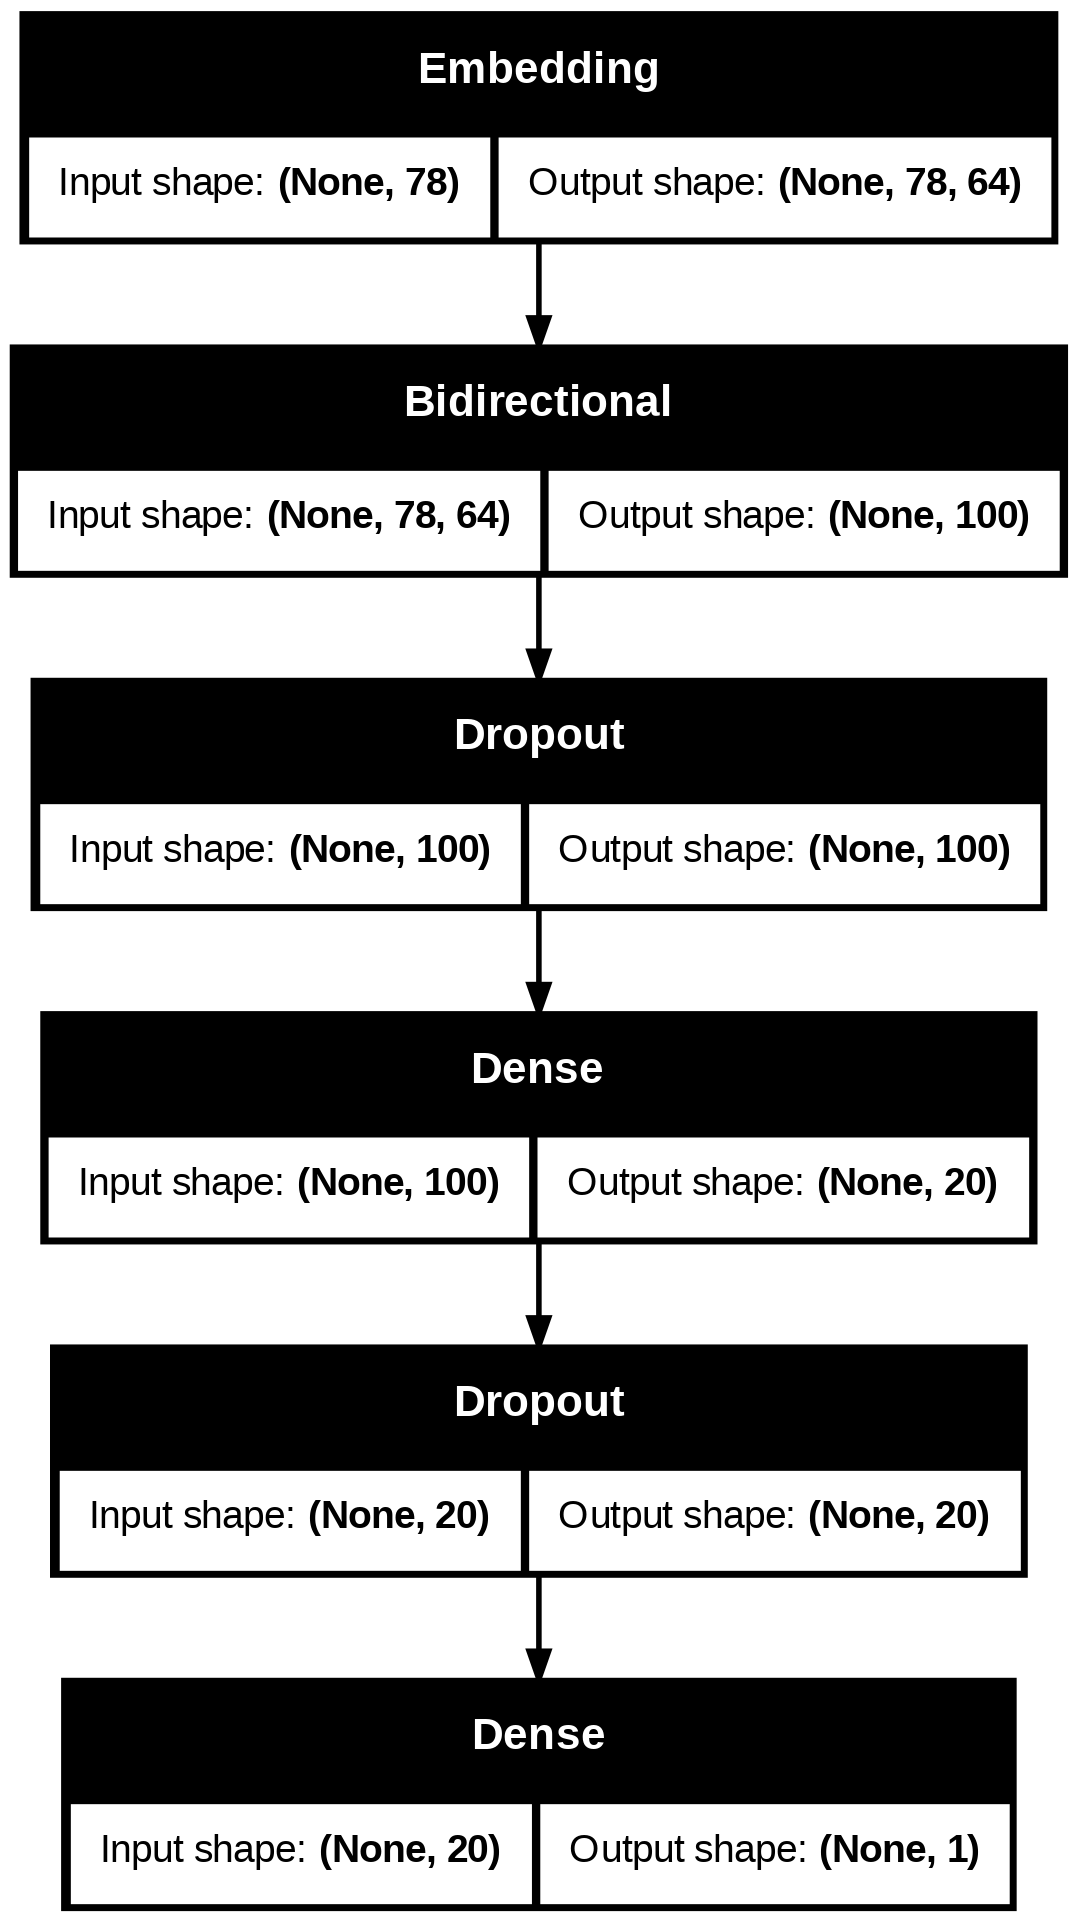

In [ ]:
# display LSTM model architecture
plot_model(model, to_file='model.png', show_shapes=True)
Image(filename='model.png')

**Step 6:** Train LSTM model

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# stop training if validation loss does not improve after 10 epochs
early_stop = EarlyStopping(
    monitor='val_loss',        # monitor validation loss
    patience=10,               # wait for 15 epochs
    restore_best_weights=True  # restore model weights from best epoch
)

# save the model if the validation loss decreases
checkpoint = ModelCheckpoint(
    'model_1.h5',        # model file name
    monitor='val_loss',  # monitor validation loss
    save_best_only=True  # save only the best model
)

# divide the learning rate of the optimizer by 3 if the validation loss does not improve after 3 epochs
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',        # monitor validation loss
    factor=1/10,               # divide LR by 10
    patience=3,                # wait 3 epochs with no improvement
    min_lr=1e-7,               # prevent LR from going too low
    verbose=1
)

In [ ]:
history = model.fit(
    X_train_padded,
    y_train_encoded,
    epochs=20,
    batch_size=15,
    validation_data=(X_val_padded, y_val_encoded),
    callbacks=[checkpoint, early_stop , reduce_lr]
)

Epoch 1/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9102 - loss: 0.2634

242/242 ━━━━━━━━━━━━━━━━━━━━ 29s 76ms/step - accuracy: 0.9104 - loss: 0.2629 - val_accuracy: 0.9696 - val_loss: 0.1036 - learning_rate: 0.0010
Epoch 2/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9907 - loss: 0.0354

242/242 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.9907 - loss: 0.0354 - val_accuracy: 0.9753 - val_loss: 0.0983 - learning_rate: 0.0010
Epoch 3/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 19s 74ms/step - accuracy: 0.9955 - loss: 0.0130 - val_accuracy: 0.9696 - val_loss: 0.1071 - learning_rate: 0.0010
Epoch 4/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.9970 - loss: 0.0102 - val_accuracy: 0.9791 - val_loss: 0.1350 - learning_rate: 0.0010
Epoch 5/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9995 - loss: 0.0019
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
242/242 ━━━━━━━━━━━━━━━━━━━━ 24s 100ms/step - accuracy: 0.9995 - loss: 0.0019 - val_accuracy: 0.9772 - val_loss: 0.1155 - learning_rate: 0.0010
Epoch 6/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 37s 153ms/step - accuracy: 0.9997 - loss: 0.0037 - val_accuracy: 0.9772 - val_loss: 0.1231 - learning_rate: 1.0000e-04
Epoch 7/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - accuracy: 0.9998 - loss: 

**Step 7:**  Plot the training and validation loss and accuracy over epochs

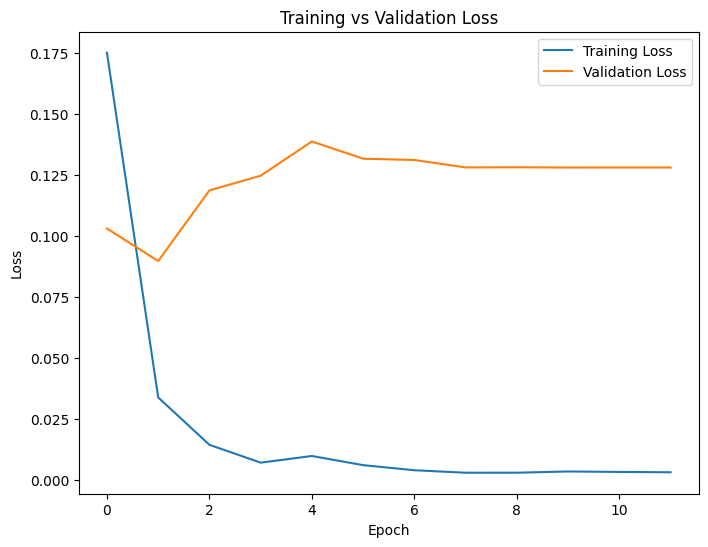

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

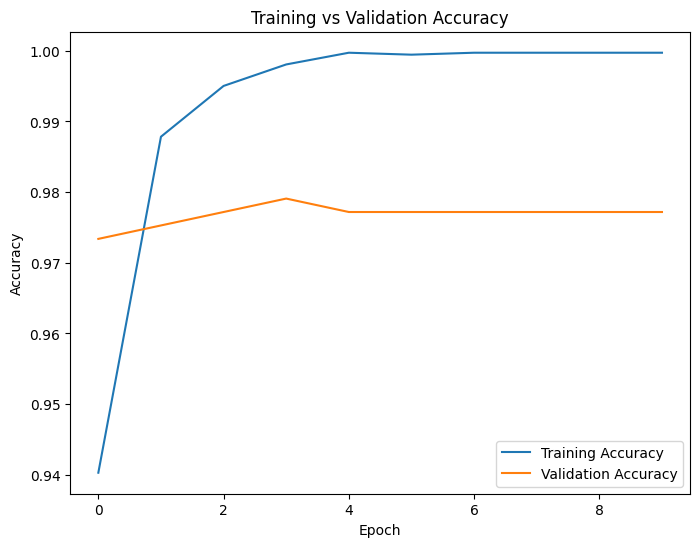

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

**Step 8:** Make predictions on the test set

In [ ]:
# load model
model = load_model("model_1.h5")

# evaluate model
loss, acc = model.evaluate(X_test_padded, y_test_encoded)

# make predictions on the test set
y_pred_test = model.predict(X_test_padded)

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9462 - loss: 0.2044
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step


In [ ]:
# Convert the predictions to class labels
threshold = 0.5     # Choose the threshold value in the range [0 .. 1]
y_pred_classes_test  = (y_pred_test > threshold).astype(int) # 1 if probability > 0.5 else 0



**Step 9:** Confusion matrix


['ham' 'spam']
Classification report LSTM:

               precision    recall  f1-score   support

           0       0.98      1.00      0.99       895
           1       0.97      0.86      0.91       130

    accuracy                           0.98      1025
   macro avg       0.98      0.93      0.95      1025
weighted avg       0.98      0.98      0.98      1025
 



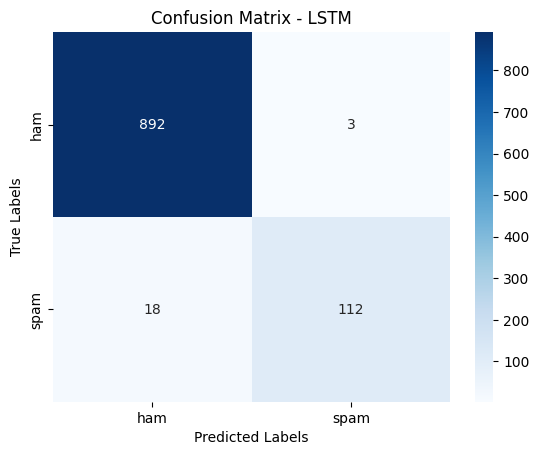

In [ ]:
# confusion matrix : Rows → true labels (y_test_encoded), Columns → predicted labels (y_pred_classes_test)
conf_matrix=confusion_matrix(y_test_encoded, y_pred_classes_test )

print(np.unique(y_test)) # ['ham' 'spam'] => row 0 = ham, row 1 = spam

class_rep_LSTM = classification_report(y_test_encoded, y_pred_classes_test )

print('Classification report LSTM:\n\n', class_rep_LSTM, '\n')

# plot confusion matrix: row 0 = ham, row 1 = spam
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - LSTM')
plt.show()